In [77]:
import pandas as pd
import random as rd
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import deque  
SEED = 27 
rd.seed(SEED)
np.random.seed(SEED)

In [78]:
class QuantumNetwork:
    def __init__(self, initialEdges, pGen, cutOffAge, maxLinks):
        self.initialEdges = initialEdges
        self.pGen = pGen
        self.cutOffAge = cutOffAge
        self.maxLinks = maxLinks
        
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(sorted(nodes))
    
    def reset(self):
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(nodes)
    
    def getState(self):
        edge_info = {}
        for edge in self.G.edges():
            edge_info[edge] = list(self.G.edges[edge]['entanglements']) 
        return edge_info
    
    def ageEntanglements(self):
        for edge in self.G.edges():
            entanglements = self.G.edges[edge]['entanglements']
            updated = deque(age + 1 for age in entanglements if age + 1 <= self.cutOffAge)
            self.G.edges[edge]['entanglements'] = updated
            if len(updated) == 0:
                self.G.remove_edge(*edge)
    
    def generateGlobalEntanglementsProbabalistically(self):
        for edge in self.initialEdges:
            if rd.random() < self.pGen:
                self.generateLocalEntanglement(*edge)
    
    def generateLocalEntanglement(self, node1, node2):
        edge = tuple(sorted([node1, node2]))
        
        node1_entanglements = sum(len(self.G.edges[e]['entanglements']) 
                                for e in self.G.edges(node1)) if self.G.degree(node1) > 0 else 0
        node2_entanglements = sum(len(self.G.edges[e]['entanglements']) 
                                for e in self.G.edges(node2)) if self.G.degree(node2) > 0 else 0
        
        if node1_entanglements >= self.maxLinks or node2_entanglements >= self.maxLinks:
            return 
        
        if not self.G.has_edge(*edge):
            self.G.add_edge(*edge, entanglements=deque([0]))
        else:
            if len(self.G.edges[edge]['entanglements']) < self.maxLinks:
                self.G.edges[edge]['entanglements'].appendleft(0)
    
    def discardEntanglement(self, edge: tuple):
        if self.G.has_edge(*edge):
            if len(self.G.edges[edge]['entanglements']) > 0:
                self.G.edges[edge]['entanglements'].pop()
            if len(self.G.edges[edge]['entanglements']) == 0:
                self.G.remove_edge(*edge)
                
                
    def performEntanglementSwapping(self, edge1, edge2):
        if not (self.G.has_edge(*edge1) and self.G.has_edge(*edge2)):
            print('One or both edges not found')
            return
            
        common_nodes = set(edge1) & set(edge2)
        if len(common_nodes) != 1:
            print('Edges do not share exactly one node')
            return
        common_node = common_nodes.pop()
        
        # Find the outer nodes that will form the new edge
        outer_nodes = (set(edge1) | set(edge2)) - {common_node}
        new_edge = tuple(sorted(outer_nodes))
        
        # Get the youngest entanglement from each parent edge
        """
        ASK THIRU
        
        """
        # Find the youngest entanglements and their indices
        age1 = min(self.G.edges[edge1]['entanglements'])
        age2 = min(self.G.edges[edge2]['entanglements'])
        idx1 = list(self.G.edges[edge1]['entanglements']).index(age1)
        idx2 = list(self.G.edges[edge2]['entanglements']).index(age2)
        
        # Create new edge with age being the max of the two parent entanglements
        new_age = max(age1, age2)
        
        # Remove the specific entanglements we used
        self.G.edges[edge1]['entanglements'].rotate(-idx1)
        self.G.edges[edge1]['entanglements'].pop()
        if len(self.G.edges[edge1]['entanglements']) == 0:
            self.G.remove_edge(*edge1)
            
        self.G.edges[edge2]['entanglements'].rotate(-idx2)
        self.G.edges[edge2]['entanglements'].pop()
        if len(self.G.edges[edge2]['entanglements']) == 0:
            self.G.remove_edge(*edge2)
        
        # Add the new edge with the calculated age
        if not self.G.has_edge(*new_edge):
            self.G.add_edge(*new_edge, entanglements=deque([new_age]))
        else:
            if len(self.G.edges[new_edge]['entanglements']) < self.maxLinks:
                self.G.edges[new_edge]['entanglements'].appendleft(new_age)
         
    def drawNetwork(self):
        plt.figure(figsize=(12, 8))
        plt.clf()
        
        G_viz = self.G.copy()
        G_viz.add_edges_from(self.initialEdges)
        
        # FIXED POSITION FOR DUMBELL NETWORK
        pos = {
            0: (-1, 0.5),   # Top left
            1: (-1, -0.5),  # Bottom left
            2: (0, 0),      # Center
            3: (1, 0),      # Center right
            4: (2, 0.5),    # Top right
            5: (2, -0.5)    # Bottom right
        }
        # pos = nx.spring_layout(G_viz, seed=27)

        
        # Rest of the visualization code remains the same
        nx.draw_networkx_edges(G_viz, pos=pos, 
                            edgelist=self.initialEdges,
                            edge_color='grey',
                            style='dashed',
                            alpha=0.5)
        
        for edge in self.G.edges():
            entanglements = self.G.edges[edge]['entanglements']
            for i, age in enumerate(entanglements):
                nx.draw_networkx_edges(G_viz, pos=pos,
                                    edgelist=[edge],
                                    edge_color='blue',
                                    width=2,
                                    arrows=True,
                                    connectionstyle=f'arc3, rad={-0.1 + i*0.2}')
                
                edge_x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
                edge_y = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
                offset = -0.1 + i*0.2
                label_x = edge_x + offset * (pos[edge[1]][1] - pos[edge[0]][1]) / 2
                label_y = edge_y - offset * (pos[edge[1]][0] - pos[edge[0]][0]) / 2
                plt.text(label_x, label_y, str(age), 
                        bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.7))
        
        nx.draw_networkx_nodes(G_viz, pos=pos, node_color='lightblue')
        nx.draw_networkx_labels(G_viz, pos=pos)
        
        plt.show()

In [85]:
class Enivornment(QuantumNetwork):
    def __init__(self, initialEdges, pGen, cutOffAge, maxLinks, goalEdgesAndWeights):
        super().__init__(initialEdges, pGen, cutOffAge, maxLinks)
        self.goalEdgesAndWeights = goalEdgesAndWeights
    
    def getReward(self):
        pass
    
    def isTerminal(self):
        # Return true if one or more goal edges are present in the graph
        for goal_edge, _ in self.goalEdgesAndWeights:
            goal_edge = tuple(sorted(goal_edge))
            if self.G.has_edge(*goal_edge):
                return True
        return False

    def getPossibleActions123(self):
        # Returns all possible actions i.e.
        # Returns all possbile swaps
        # Swaps can be simultaneous/ one after another..
            #i.e. if we have (1,2) (2,3) and (3,4)
            # We can swap (1,2)(2,3) and then swap the resuklting (1,3) and (3,4)
        #It's worth noting, that we consume swaps as we use them (creating the new swap)
        # and that we can't break the rules of maxaimum links per node
        pass
    
    def getPossibleActions(self):
        def simulate_swap(graph, edge1, edge2):
            # Returns new graph and new edge after swap
            new_graph = graph.copy()
            common_node = (set(edge1) & set(edge2)).pop()
            outer_nodes = tuple(sorted((set(edge1) | set(edge2)) - {common_node}))
            
            # Get the ages of entanglements we'll use
            age1 = min(graph.edges[edge1]['entanglements'])
            age2 = min(graph.edges[edge2]['entanglements'])
            new_age = max(age1, age2)
            
            # Remove old edges
            new_graph.remove_edge(*edge1)
            new_graph.remove_edge(*edge2)
            
            # Add new edge with proper entanglement
            new_graph.add_edge(*outer_nodes, entanglements=deque([new_age]))
            return new_graph, outer_nodes

        def find_all_swaps(graph):
            # Find all valid swaps in current graph state
            swaps = []
            for edge1, edge2 in itertools.combinations(graph.edges(), 2):
                # Check if edges share exactly one node
                common_nodes = set(edge1) & set(edge2)
                if len(common_nodes) != 1:
                    continue
                    
                # Check maxLinks constraint
                outer_nodes = tuple(sorted((set(edge1) | set(edge2)) - common_nodes))
                node1, node2 = outer_nodes
                node1_count = sum(len(graph.edges[e]['entanglements']) 
                                for e in graph.edges(node1)) if graph.degree(node1) > 0 else 0
                node2_count = sum(len(graph.edges[e]['entanglements']) 
                                for e in graph.edges(node2)) if graph.degree(node2) > 0 else 0
                
                if node1_count < self.maxLinks and node2_count < self.maxLinks:
                    swaps.append((edge1, edge2))
            return swaps

        def find_sequences(current_graph, current_sequence, all_sequences, seen_sequences, depth=0):
            if depth > 2:  # Limit sequence length
                return
                
            possible_swaps = find_all_swaps(current_graph)
            
            for edge1, edge2 in possible_swaps:
                new_sequence = current_sequence + [(edge1, edge2)]
                # Convert sequence to tuple for hashability
                sequence_tuple = tuple(sorted(new_sequence))
                if sequence_tuple not in seen_sequences:
                    seen_sequences.add(sequence_tuple)
                    all_sequences.append(new_sequence)
                
                new_graph, _ = simulate_swap(current_graph, edge1, edge2)
                find_sequences(new_graph, new_sequence, all_sequences, seen_sequences, depth + 1)

        # Start with empty sequence
        possible_actions = [[]]
        seen_sequences = set()  # Keep track of sequences we've already added
        
        # Find all basic swaps
        basic_swaps = find_all_swaps(self.G)
        
        # Generate single swaps and simultaneous swaps
        for r in range(1, len(basic_swaps) + 1):
            for swap_combo in itertools.combinations(basic_swaps, r):
                # Check if swaps are independent
                used_edges = set()
                valid = True
                for edge1, edge2 in swap_combo:
                    if edge1 in used_edges or edge2 in used_edges:
                        valid = False
                        break
                    used_edges.add(edge1)
                    used_edges.add(edge2)
                
                if valid:
                    sequence = list(swap_combo)
                    sequence_tuple = tuple(sorted(sequence))
                    if sequence_tuple not in seen_sequences:
                        seen_sequences.add(sequence_tuple)
                        possible_actions.append(sequence)
        
        # Find sequential swaps
        find_sequences(self.G, [], possible_actions, seen_sequences)
        
        return possible_actions

In [88]:
initialEdges = [
    (0, 2),
    (1, 2),
    (2, 3),
    (3, 4),
    (3, 5)]
rd.seed(25)
goalEdgesAndWeights = [((1,5), 0.7), ((1,4), 0.3)]
network = Enivornment(initialEdges=initialEdges, pGen=0.5, cutOffAge=2, maxLinks=4, goalEdgesAndWeights=goalEdgesAndWeights) # I.e. max links per node is maxLinks
network.generateGlobalEntanglementsProbabalistically()
network.generateGlobalEntanglementsProbabalistically()
print(network.getState())
network.getPossibleActions() 


{(0, 2): [0], (1, 2): [0], (3, 4): [0, 0], (3, 5): [0]}


[[],
 [((0, 2), (1, 2))],
 [((3, 4), (3, 5))],
 [((0, 2), (1, 2)), ((3, 4), (3, 5))]]

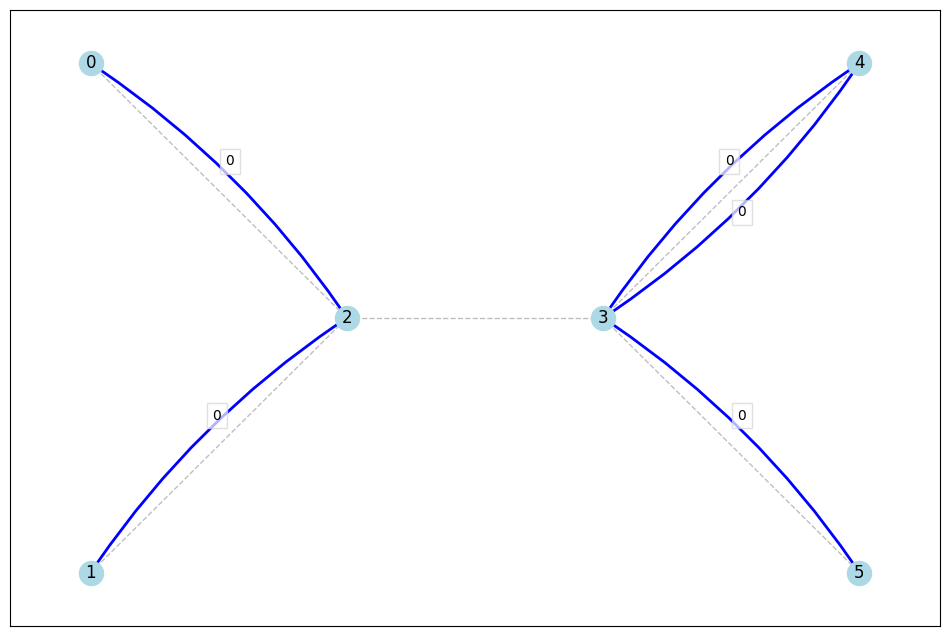

In [89]:
network.drawNetwork()
